<img src="tic3151.png" style="height: 70px; width: 200px" align=left> 
<img src="logo-MMU.png" style="height: 70px; width: 200px" align=right> 

### Team members

Ahmad Ayaan - 1191302794 

Salah Fayeq y. AlHaismawi - 1201303035

Aisha Sakinah Binti Saadon - 1191101867

Aryssa Amanda Binti Azhar - 1191100575


### The assignment contains following questions


# Installing Libraries

##### Note: Uncomment the code the code to install the relevant libraries

In [1]:
# pip install matplotlib.pyplot
# pip install ortools
# pip install pulp

# Importing Libraries

In [2]:
from random import randint
import random
from tabulate import tabulate
import numpy as np
from ortools.sat.python import cp_model
from tabulate import tabulate
import matplotlib.pyplot as plt


# Question 1

Year-end school holiday is coming soon. A kindergarten teacher would like to give each
of the student in her class, an amazing holiday set by November 2023. There are 25
students in her class consisting of 15 girls and 10 boys. She has approached you for
help and provided the following details to you:

• Budget for 25 holiday sets = RM 200.00

• Each holiday set must be wrapped using a sheet of paper i.e. blue wrapper for
boy’s holiday set and pink wrapper for girl’s holiday set. Each wrapper cost
RM1.00

• Each holiday set should have at least 2 items being stationery



## Variables Declaration

In [3]:
# Constant variables
budget = 200.00
minimum_stationary_item = 2
wrapper_cost = 1.00

# List of items and their prices
items = [
    ("Chipsmore Biscuit", 2.00),
    ("2B pencil", 1.00),
    ("Color pencil", 3.00),
    ("Magic pen", 3.00),
    ("Potato chip", 2.00),
    ("Milo packet", 1.00),
    ("Mini sketch book", 2.00),
    ("Milk biscuit", 3.00)
]

mutation_rate = 0.1
wrapper_cost = 1 * 25  # Wrapper cost for 25 sets

## Population and Individuals



In [4]:
def individuals():
    return [random.randint(0, 1) for items in range(len(items))]

def generate_population(population_size):
    return [individuals() for x in range(population_size)]

## Fitness Function

The fitness function calculates the total cost of items in a chromosome, after deducting the cost of wrappers and ensuring that atleast 2 of the items are stationery.

In [5]:
def fitness_function(chromosome):
    total = 0
    num_stationery_items = 0
    num_items = 0
    for i, j in enumerate(chromosome):
        if j == 1:
            # to calculate the total cost of the items present in the set
            total += items[i][1]
            num_items += 1
            # to check if the current sets have stationery
            if items[i][0] in ["2B pencil", "Color pencil", "Magic pen", "Mini sketch book"]:
                num_stationery_items += 1

    if num_stationery_items >= 2 and (total*25) + wrapper_cost <=budget:
         # Calculate the fitness score based on the weighted sum of total cost and number of items
        total_score = total * num_items
        items_score = num_items * 10
        score = total_score + items_score
        #print(score)
        return score
    else:
        return 0 if total <= 200 else -1

## Selection Function

In [6]:
"""Perform selection using roulette wheel selection."""
def selection_roulette_wheel(population, fitness_values):
    total_fitness = sum(fitness_values)
    if total_fitness == 0:
        probabilities = [1 / len(population)] * len(population)
    else:
        probabilities = [fitness / total_fitness for fitness in fitness_values]
    selected = random.choices(population, weights=probabilities, k=2)
    return selected[0], selected[1]


"""Perform selection using rank selection."""
def selection_rank(population, fitness_values):
    ranked_population = sorted(zip(population, fitness_values), key=lambda x: x[1], reverse=True)
    selected = []
    while len(selected) < 2:
        for chromosome, fitness in ranked_population:
            if fitness > 0:  # Select only individuals with positive fitness
                selected.append(chromosome.copy())
                if len(selected) == 2:
                    break
    return selected[0], selected[1]


## Crossover Function

In [7]:
"""Perform crossover using single point crossover."""
def crossover_single_point(parent1, parent2):
    single_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:single_point] + parent2[single_point:]
    child2 = parent2[:single_point] + parent1[single_point:]
    return child1, child2

"""Perform crossover using two point crossover."""
def crossover_two_point(parent1, parent2):
    two_point = sorted(random.sample(range(len(parent1)), 2))
    child1 = parent1[:two_point[0]] + parent2[two_point[0]:two_point[1]] + parent1[two_point[1]:]
    child2 = parent2[:two_point[0]] + parent1[two_point[0]:two_point[1]] + parent2[two_point[1]:]
    return child1, child2

## Mutation Function

In [8]:
"""Perform inversion mutation."""
def mutation_inversion(chromosome):
    start = random.randint(0, len(chromosome) - 1)
    end = random.randint(start + 1, len(chromosome))
    mutated_chromosome = chromosome[:start] + chromosome[start:end][::-1] + chromosome[end:]
    return mutated_chromosome

"""Perform bit flipping mutation."""
def mutation_bit_flip(chromosome):
    mutated_chromosome = chromosome[:]
    for i in range(len(mutated_chromosome)):
        if random.random() < mutation_rate:
            mutated_chromosome[i] = 1 - mutated_chromosome[i]
    return mutated_chromosome

## Main Function

In [9]:
def evolve(population, fitness_values, selection_method, crossover_method, mutation_method):
    next_generation = []
    while len(next_generation) < 25:
        parent1, parent2 = selection_method(population, fitness_values)
        #print(parent1, parent2)
        offspring1, offspring2 = crossover_method(parent1, parent2)
        #print(offspring1, offspring2)
        offspring1 = mutation_method(offspring1)
        offspring2 = mutation_method(offspring2)
        next_generation.extend([offspring1, offspring2])
        #print(next_generation)
    return next_generation[:25]


In [10]:
def main(selection_method, crossover_method, mutation_method):
    # Generate an initial population
    population = generate_population(25)
    
    # Calculate fitness values for each chromosome
    fitness_values = [fitness_function(chromosome) for chromosome in population]
    fitness_history = []

    best_fitness = float('inf')
    best_combination = []

    for generation in range(100):
        # Select parents and perform crossover and mutation
        population = evolve(population, fitness_values, selection_method, crossover_method, mutation_method)

        # Calculate fitness values for each chromosome
        fitness_values = [fitness_function(chromosome) for chromosome in population]
        fitness_history.append(max(fitness_values))

       # Find the best fitness value and corresponding combination
    best_fitness = max(fitness_values)
    best_combination = population[fitness_values.index(best_fitness)].copy()


    # Display the total combination and the content of the combination
    print("Total Combination of Items: ")
    total_combination = sum(best_combination)
    print(total_combination)

    print("Content of the Combination of Items:")
    selected_items = []
    unit_price = 0
    for i, item in enumerate(best_combination):
        if item == 1:
            item_name = items[i][0]
            item_price = items[i][1]
            unit_price += item_price
            selected_items.append([item_name, item_price])
            
    selected_items.append(['Wrapper cost', '1'])
    unit_price +=1
    print(tabulate(selected_items, headers=["Item Name", "Price (RM)"], tablefmt="grid"))

    print("Unit Price: ")
    print(unit_price if best_fitness >= 0 else 0)
    
    print("Total Price: ")
    print(unit_price * 25 if best_fitness >= 0 else 0)
    
    return best_combination, fitness_history


## Perfomance Assessment



In [11]:
# Test 1
print("Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):")
print()
best_holiday_set_1, fitness_history_1 = main(selection_roulette_wheel, crossover_two_point, mutation_bit_flip)

Best holiday set (Selection Method: Ranked, Crossover Method: Single Point, Mutation Method: Inversion):

Total Combination of Items: 
4
Content of the Combination of Items:
+------------------+--------------+
| Item Name        |   Price (RM) |
+==================+==============+
| 2B pencil        |            1 |
+------------------+--------------+
| Color pencil     |            3 |
+------------------+--------------+
| Milo packet      |            1 |
+------------------+--------------+
| Mini sketch book |            2 |
+------------------+--------------+
| Wrapper cost     |            1 |
+------------------+--------------+
Unit Price: 
8.0
Total Price: 
200.0


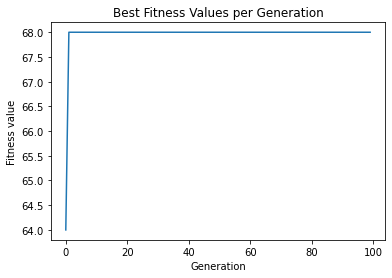

In [12]:
x = range(0,len(fitness_history_1))
y = fitness_history_1

plt.plot(x, y)

plt.title("Best Fitness Values per Generation")
plt.xlabel("Generation")
plt.ylabel("Fitness value")

plt.show()

## Summary


# Question 2



## Variable declaration

In [17]:
# Define the teams, days, and slots
slots = [1, 2, 3, 4, 5, 6]
teams = [1, 2, 3, 4, 5, 6, 7]
days = [1, 2, 3, 4]
solution_limit = 100  # Number of solutions to print

In [18]:
def solve_dodol_feast(minimum_slot):
     # Create the CP-SAT model
    model = cp_model.CpModel()

    # Create the decision variables
    variables = {}
    for day in days:
        for slot in slots:
            for team in teams:
                variables[(day, slot, team)] = model.NewBoolVar(f'time_{team}_{day}_{slot}')

    # Constraint 1: Each team must stir the pot for at least 3 times during the feast
    for team in teams:
        model.Add(sum(variables[(day, slot, team)] for day in days for slot in slots) >= minimum_slot)

    # Constraint 2: No team should stir the pot for more than 4 hours a day
    for day in days:
        for team in teams:
            model.Add(sum(variables[(day, slot, team)] for slot in slots) <= 1)

    # Constraint 3: No team should stir the pot consecutively
    for day in days:
        for slot in slots[1:]:
            for team in teams:
                model.Add(variables[(day, slot, team)] <= sum(variables[(day, slot - 1, t)] for t in teams if t != team))

    # Constraint 4: Only one team should stir the pot in each time slot
    for day in days:
        for slot in slots:
            model.Add(sum(variables[(day, slot, team)] for team in teams) == 1)

    # Create the objective variable
    objective_var = model.NewIntVar(0, len(days) * len(slots) * len(teams), 'objective')

    # Constraint 5: Minimize the total number of team assignments
    model.Add(objective_var == sum(variables[(day, slot, team)] for day in days for slot in slots for team in teams))

    # Set the objective function
    model.Minimize(objective_var)

    # Create the solver
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = True
    solutions_found = 0
    all_solutions = []

    while solutions_found < solution_limit:
        status = solver.Solve(model)

        # Check if a solution is found
        if status != cp_model.OPTIMAL:
            print("No feasible solution found.")
            break

        # Extract the solution
        solution = {}
        for day in days:
            for slot in slots:
                for team in teams:
                    if solver.BooleanValue(variables[(day, slot, team)]):
                        solution[(day, slot)] = team

        all_solutions.append(solution)
        solutions_found += 1

        # Add a new constraint to prevent finding the same solution again
        model.Add(sum(variables[(day, slot, team)] for day in days for slot in slots for team in teams
                      if solution.get((day, slot)) == team) <= len(solution) - 1)

    return all_solutions

## Main Functions

In [20]:
# Solve the dodol feast problem and get all possible schedules
all_solutions_1 = solve_dodol_feast(2)

if all_solutions_1:
    solution_idx = 0  # Index of the solution to print (99 for the first solution)
    solution = all_solutions_1[solution_idx]
    print(f"Sample Schedule:")
    table = []
    for day in days:
        row = [f"Day {day}"]
        for slot in slots:
            team = solution.get((day, slot), "-")
            row.append(f"Team {team}")
        table.append(row)
    headers = [""] + [f"Time Slot {slot}" for slot in slots]
    print(tabulate(table, headers=headers, showindex=False, tablefmt="grid"))
    print()
else:
    print("No feasible solution found.")


Sample Schedule:
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
|       | Time Slot 1   | Time Slot 2   | Time Slot 3   | Time Slot 4   | Time Slot 5   | Time Slot 6   |
+=======+===============+===============+===============+===============+===============+===============+
| Day 1 | Team 7        | Team 6        | Team 5        | Team 3        | Team 2        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 2 | Team 7        | Team 5        | Team 4        | Team 3        | Team 2        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 3 | Team 6        | Team 5        | Team 4        | Team 3        | Team 2        | Team 1        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 4 | Team 7        | Tea

In [21]:
# Solve the dodol feast problem and get all possible schedules
all_solutions_2 = solve_dodol_feast(3)

if all_solutions_2:
    solution_idx = 0  # Index of the solution to print (0 for the first solution)
    solution = all_solutions_2[solution_idx]
    print(f" Sample Schedule:")
    table = []
    for day in days:
        row = [f"Day {day}"]
        for slot in slots:
            team = solution.get((day, slot), "-")
            row.append(f"Team {team}")
        table.append(row)
    headers = [""] + [f"Time Slot {slot}" for slot in slots]
    print(tabulate(table, headers=headers, showindex=False, tablefmt="grid"))
    print()
else:
    print("No feasible solution found.")


 Sample Schedule:
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
|       | Time Slot 1   | Time Slot 2   | Time Slot 3   | Time Slot 4   | Time Slot 5   | Time Slot 6   |
+=======+===============+===============+===============+===============+===============+===============+
| Day 1 | Team 7        | Team 1        | Team 3        | Team 4        | Team 6        | Team 5        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 2 | Team 5        | Team 4        | Team 6        | Team 2        | Team 1        | Team 7        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 3 | Team 6        | Team 3        | Team 4        | Team 2        | Team 1        | Team 5        |
+-------+---------------+---------------+---------------+---------------+---------------+---------------+
| Day 4 | Team 7        | Te

## Matplot to show the constrast

In [ ]:
# Calculate the average number of slots worked for each team (First Solution)
team_slots_1 = {team: 0 for team in teams}
for solution in all_solutions_1:
    for team in teams:
        team_slots_1[team] += sum(1 for day in days for slot in slots if solution.get((day, slot)) == team)

average_slots_1 = {team: slots / len(all_solutions_1) for team, slots in team_slots_1.items()}

# Calculate the average number of slots worked for each team (Second Solution)
team_slots_2 = {team: 0 for team in teams}
for solution in all_solutions_2:
    for team in teams:
        team_slots_2[team] += sum(1 for day in days for slot in slots if solution.get((day, slot)) == team)

average_slots_2 = {team: slots / len(all_solutions_2) for team, slots in team_slots_2.items()}

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first solution
axes[0].bar(teams_labels, [average_slots_1[team] for team in teams])
axes[0].set_xlabel('Team')
axes[0].set_ylabel('Average Slots Worked')
axes[0].set_title('Average Number of Slots Worked for Each Team (First Solution)')

# Plot the second solution
axes[1].bar(teams_labels, [average_slots_2[team] for team in teams])
axes[1].set_xlabel('Team')
axes[1].set_ylabel('Average Slots Worked')
axes[1].set_title('Average Number of Slots Worked for Each Team (Second Solution)')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## Summary

# Question 3


### Player list

In [ ]:
import pandas as pd
import numpy as np

# Load data
playerlist = pd.read_csv("Question-3-Dataset/NBA-playerlist.csv")
playerlist 

In [ ]:
# Drop unnecessary columns
playerlist = playerlist.drop(['Unnamed: 0', 'DISPLAY_LAST_COMMA_FIRST'], axis=1)
playerlist = playerlist.rename(columns={'DISPLAY_FIRST_LAST': 'PLAYER_NAME'})

# Rearrange the columns
person_id_col = playerlist.pop('PERSON_ID')  # Remove 'PERSON_ID' column from DataFrame
playerlist.insert(0, 'PERSON_ID', person_id_col)  # Insert 'PERSON_ID' column at the front

# Display data
playerlist

In [ ]:
# Check data types
print(playerlist.columns)
playerlist.dtypes

<b> Handle duplicates and missing values

In [ ]:
def check_duplicates(data):
    duplicate_rows = data[data.duplicated()]
    print("Duplicate Rows:", len(duplicate_rows))
    
    if len(duplicate_rows) > 0:
        data.drop_duplicates(inplace=True)
        print("Duplicate rows dropped.")
        
def check_missing_values(data):
    has_missing_values = False  # Flag variable

    for column in data.columns:
        null_val = data[column].isna().sum()
        total_data = len(data[column])

        if null_val > 0:
            print(column, ":", null_val, "out of", total_data)
            has_missing_values = True  # Set the flag to True if missing values are found

    # Print "No missing values" if no missing values were found
    if not has_missing_values:
        print("No missing values.")

In [ ]:
# Check duplicte data
check_duplicates(playerlist)
print()

# Check missing value
print("Missing values =======================")
check_missing_values(playerlist)

# Check TEAM_ID with 0 as value:
total_null = len(playerlist[playerlist['TEAM_ID'] == 0])
total_data = len(playerlist['TEAM_ID'])
print('TEAM_ID : ', total_null, "out of", total_data)

# Replace TEAM_ID with 0 as value to "-"
playerlist['TEAM_ID'] = playerlist['TEAM_ID'].replace(0, '-')

<b>Explaination for team abbreviation, city, code, ID and name being null

Roster status 0 means the player is not active, therefore there no team data recorded<br>
Roster status 1 means the player is active, therefore there team data recorded<b>

In [ ]:
# Check if columns are null when ROSTERSTATUS is 0
null_values_roster_0 = playerlist.loc[playerlist['ROSTERSTATUS'] == 0, ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']].isnull().sum()
print("Null values when ROSTERSTATUS is 0:")
print(null_values_roster_0)
print()

# Check if columns have values when ROSTERSTATUS is 1
not_null_values_roster_1 = playerlist.loc[playerlist['ROSTERSTATUS'] == 1, ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']].notnull().sum()
print("Non-null values when ROSTERSTATUS is 1:")
print(not_null_values_roster_1)

# Fill NaN value with "-"
columns_to_fill = ['TEAM_ABBREVIATION', 'TEAM_CITY', 'TEAM_CODE', 'TEAM_NAME']
playerlist[columns_to_fill] = playerlist[columns_to_fill].fillna('-')
playerlist

<b>Explaination for missing playercode

In [ ]:
playerlist['PLAYERCODE'] = playerlist['PLAYERCODE'].fillna("-")

In [ ]:
# Check inconsistency
for column in playerlist.columns:
    val_count = playerlist[column].value_counts()
    print("value count for ", column, ":")
    print(val_count)
    print()

For the observation:
- TEAM_CITY has both LA and Los Angeles

In [ ]:
# Replace "LA" with "Los Angeles"
playerlist['TEAM_CITY'] = playerlist['TEAM_CITY'].replace('LA', 'Los Angeles')

# Count the occurrences of each team name again
team_counts = playerlist['TEAM_CITY'].value_counts()

# Print the updated team counts
print(team_counts)

<b> Finalized cleaned data

In [ ]:
check_missing_values(playerlist)

In [ ]:
playerlist.to_excel('playerlist_cleaned.xlsx', index=False)

### NBA Season Data

In [ ]:
import pandas as pd
import numpy as np

NBA1 = pd.read_csv("Question-3-Dataset/NBA-Season-2016-2017.csv")
NBA2 = pd.read_csv("Question-3-Dataset/NBA-Season-2017-2018.csv")
NBA3 = pd.read_csv("Question-3-Dataset/NBA-Season-2018-2020.csv")

pd.set_option('display.max_columns', None)

In [ ]:
NBA1

In [ ]:
NBA2

In [ ]:
NBA3

In [ ]:
# Drop unnecessary columns
NBA1 = NBA1.drop('Unnamed: 0', axis=1)
NBA2 = NBA2.drop('Unnamed: 0', axis=1)
NBA3 = NBA3.drop('Unnamed: 0', axis=1)

# Add a 'SEASON' column
NBA1['SEASON'] = '2016-2017'
NBA2['SEASON'] = '2017-2018'
NBA3['SEASON'] = '2018-2020'

# Merge data into one dataframe
NBA_data = pd.concat([NBA1, NBA2, NBA3], axis=0)

# # Drop this columns bcs this information is in the playerlist
# NBA_data = NBA_data.drop(['PLAYER1_TEAM_CITY', 'PLAYER2_TEAM_CITY', 'PLAYER3_TEAM_CITY',
#                          'PLAYER1_TEAM_NICKNAME', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_TEAM_NICKNAME',
#                          'PLAYER1_TEAM_ABBREVIATION', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER3_TEAM_ABBREVIATION',
#                          'PLAYER1_TEAM_CITY', 'PLAYER2_TEAM_CITY', 'PLAYER3_TEAM_CITY'], axis=1)

# Rearrange the column
game_id_col = NBA_data.pop('GAME_ID')  # Remove 'PERSON_ID' column from DataFrame
NBA_data.insert(0, 'GAME_ID', game_id_col)  # Insert 'PERSON_ID' column at the front

# Display data
NBA_data

In [ ]:
print(NBA_data.columns)
NBA_data.dtypes

In [ ]:
# Convert datatypes
columns_to_convert = ['PLAYER1_ID','PLAYER1_TEAM_ID', 
                      'PLAYER2_ID', 'PLAYER2_TEAM_ID', 
                      'PLAYER3_ID', 'PLAYER3_TEAM_ID',
                      'PERIOD','PERSON1TYPE','PERSON2TYPE', 'PERSON3TYPE']

# Fill NaN with 0, then convert float to int, then to string
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].replace([np.inf, -np.inf], np.nan).fillna(0).astype(int).astype(str)
NBA_data['GAME_ID'] = NBA_data['GAME_ID'].astype(str)

# Fill 0 back into NaN, which will handle later on
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].replace("0", np.nan)

# Display datatype
print(NBA_data.dtypes)

# Display data
NBA_data

<b> Handle duplicates and missing values

In [ ]:
# Check duplicates
check_duplicates(NBA_data)

print("Missing values =====================")

check_missing_values(NBA_data)

- SCORE AND SCOREMARGIN

In [ ]:
# Fill NaN value with "0-0", since theres no score was made during the event
NBA_data['SCORE'] = NBA_data['SCORE'].fillna('0 - 0')

# If score is "0-0", then score margin is 0
NBA_data.loc[NBA_data['SCORE'] == '0 - 0', 'SCOREMARGIN'] = 0
NBA_data[['GAME_ID', 'SCORE', 'SCOREMARGIN']]

In [ ]:
NBA_data.columns

- OTHERS

In [ ]:
# Convert datatypes
columns_to_convert = ['PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'VISITORDESCRIPTION', 'HOMEDESCRIPTION']

# Fill NaN with "-", since we can't simply replace it with other value
NBA_data[columns_to_convert] = NBA_data[columns_to_convert].fillna("-")

# Apply forward fill bcs the EVENTTYPE is during period end, so the WCTime probably follow the previous event
NBA_data['WCTIMESTRING'] = NBA_data['WCTIMESTRING'].ffill()
NBA_data['PERIOD'] = NBA_data['PERIOD'].ffill()

# Drop the this column bcs there only NaN value for every row
NBA_data = NBA_data.drop('NEUTRALDESCRIPTION', axis=1)
NBA_data

In [ ]:
EVENTMSGTYPE_mapping = {
    1: 'FIELD_GOAL_MADE',
    2: 'FIELD_GOAL_MISSED',
    3: 'FREE_THROW_ATTEMPT',
    4: 'REBOUND',
    5: 'TURNOVER',
    6: 'FOUL',
    7: 'VIOLATION',
    8: 'SUBSTITUTION',
    9: 'TIMEOUT',
    10: 'JUMP_BALL',
    11: 'EJECTION',
    12: 'PERIOD_BEGIN',
    13: 'PERIOD_END'
}

EVENTMSGACTIONTYPE_mapping = {
    1: '3PT_JUMP_SHOT',
    79: '3PT_PULLUP_JUMP_SHOT',
    80: '3PT_STEP_BACK_JUMP_SHOT',
    52: 'ALLEY_OOP_DUNK',
    108: 'CUTTING_DUNK_SHOT',
    99: 'CUTTING_FINGER_ROLL_LAYUP_SHOT',
    98: 'CUTTING_LAYUP_SHOT',
    75: 'DRIVING_FINGER_ROLL_LAYUP',
    6: 'DRIVING_LAYUP',
    73: 'DRIVING_REVERSE_LAYUP',
    7: 'DUNK',
    71: 'FINGER_ROLL_LAYUP',
    78: 'FLOATING_JUMP_SHOT',
    3: 'HOOK_SHOT',
    66: 'JUMP_BANK_SHOT',
    5: 'LAYUP',
    79: 'PULLUP_JUMP_SHOT',
    72: 'PUTBACK_LAYUP',
    44: 'REVERSE_LAYUP',
    50: 'RUNNING_DUNK',
    76: 'RUNNING_FINGER_ROLL_LAYUP',
    41: 'RUNNING_LAYUP',
    80: 'STEP_BACK_JUMP_SHOT',
    97: 'TIP_LAYUP_SHOT',
    86: 'TURNAROUND_FADEAWAY',
    58: 'TURNAROUND_HOOK_SHOT',
    47: 'TURNAROUND_JUMP_SHOT'
}

NBA_data['EVENTMSGTYPE_DESCRIPTION'] = NBA_data['EVENTMSGTYPE'].map(EVENTMSGTYPE_mapping).fillna('-')
NBA_data['EVENTMSGACTIONTYPE_DESCRIPTION'] = NBA_data['EVENTMSGACTIONTYPE'].map(EVENTMSGACTIONTYPE_mapping).fillna('-')

# Rearrange the column
NBA_data = NBA_data.reindex(columns=['GAME_ID', 'EVENTNUM', 'EVENTMSGTYPE', 'EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE', 'EVENTMSGACTIONTYPE_DESCRIPTION', 
                                     'HOMEDESCRIPTION', 'PCTIMESTRING', 'PERIOD', 'PERSON1TYPE',
                                       'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID', 'PLAYER1_NAME',
                                       'PLAYER1_TEAM_ID', 'PLAYER2_ID', 'PLAYER2_NAME', 'PLAYER2_TEAM_ID',
                                       'PLAYER3_ID', 'PLAYER3_NAME', 'PLAYER3_TEAM_ID', 'SCORE', 'SCOREMARGIN',
                                       'VISITORDESCRIPTION', 'WCTIMESTRING', 'SEASON'])
NBA_data

<b> Finalized cleaned data

In [ ]:
check_missing_values(NBA_data)

In [ ]:
playerlist.to_excel('nba_cleaned.xlsx', index=False)

## Summary